In [1]:
import hashlib
import re
import requests
import json
from datetime import date
import datetime
from dateutil.relativedelta import relativedelta
from html.parser import HTMLParser
from os import path
import matplotlib.pyplot as plt
import csv
import os
from dotenv import load_dotenv
from numpy import arange
import numpy as np
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit

In [26]:
load_dotenv()
MODE = os.getenv("MODE")  # no graphical output iff MODE=text
MODE = "haha"
url = os.getenv("URL")
url = "http://104.154.54.203/db_default/v4/nts/graph?highlight_run=147402&plot.1605933=1364.1605933.3"

In [3]:
class MyHTMLParser(HTMLParser):
    js_encountered = False

    def handle_starttag(self, tag, attrs):
#         if tag == "a":
        
        print("Encountered a start tag:", tag, attrs)

    def handle_endtag(self, tag):
        print("Encountered an end tag :", tag)

    def handle_data(self, data):
        print("Encountered some data  :", data)

In [27]:
def filter_by_date(points):
    timediff = date.today() - relativedelta(days=14)
    timediff = datetime.datetime(timediff.year, timediff.month, timediff.day)
    
#     ans = []
#     for p in points:
#         if p[2] > timediff:
#             ans.append(p)
#             print(p[2])
#     return ans
    return [p for p in points if p[2] > timediff]


In [28]:
commit2state = {}
for page in range(130):
    # fetch Buildkite data
    buildkite_url = "https://buildkite.com/llvm-project/llvm-main/builds?page={}".format(page)
    buildkite_filename = str(int(hashlib.sha256(buildkite_url.encode('utf-8')).hexdigest()[:16],
                      16)-2**63)

    if not path.exists("../../data/" + buildkite_filename):
        payload = {}

        response = requests.request("GET", buildkite_url, data=payload)

        with open("../../data/" + buildkite_filename, "w") as f:
            f.write(response.text)

    with open("../../data/" + buildkite_filename, "r") as f:
        with open("../../data/buildkite_history.txt", "a") as f2:
            for line in f:
                if "var store = new BuildStore({\"id\":" in line:
                    line = line.strip()
                    line = line.replace("var store = new BuildStore(", "[")
                    line = line[:-1] + "]"
                    buildkite_data = json.loads(line)[1]

                    for build in buildkite_data:
                        commit2state[build['commit_id']] = build['state']
                        f2.write("{} {}\n".format(build['commit_id'], build['state']))
                    break

In [29]:
def remove_noise(points):
    # remove noise using Inter Quatile Range
    # reason: we can't gurantee datasets for all benchmarks are normal, so we can't use z-score/normal distribution.
    #         IQR is the most stable algorithm I can think of
    Q1 = int(len(points)*0.1)  # quatile chosen to be 0.1 because I don't want to lose too much of data
    Q3 = int(len(points)*0.9)
    return points[Q1:Q3]

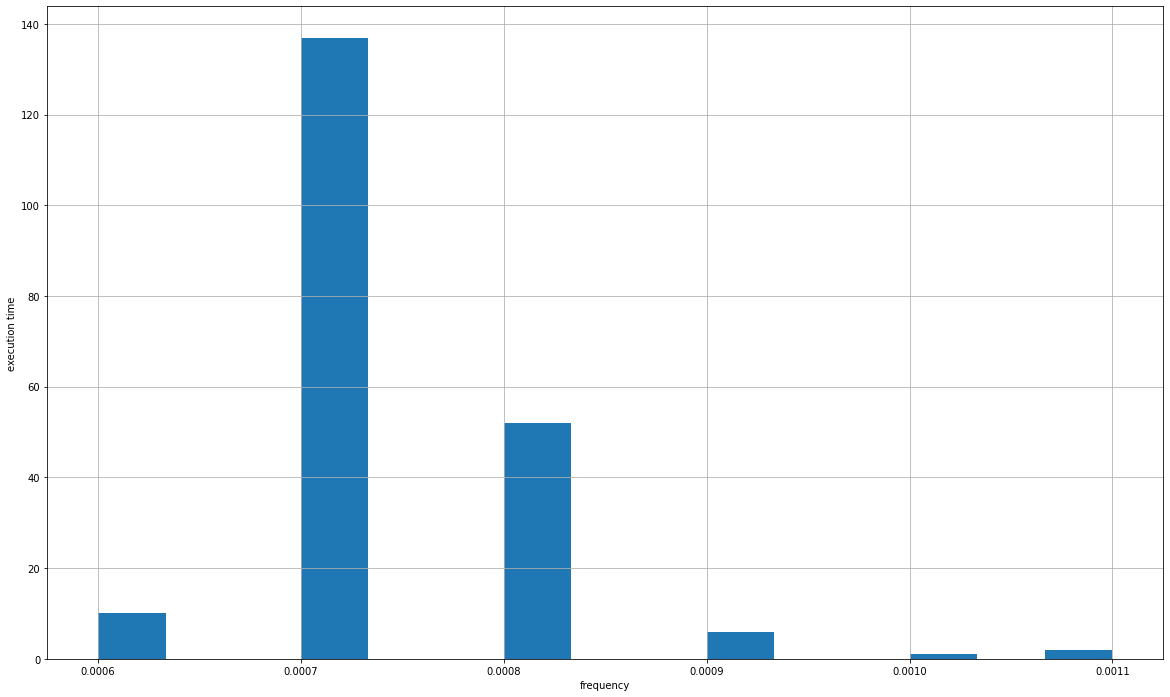

[475, 0.0007, datetime.datetime(2021, 1, 20, 20, 43, 43), {'label': '1c6d1e57c15b59114a05b20e667517872510aaa9', 'runID': '140351'}]
[500, 0.0007, datetime.datetime(2021, 6, 5, 13, 23, 21), {'label': 'dc1e7b73b81811b74a4fbde4c5cfab5a3ea7f820', 'runID': '146386'}]
[532, 0.0007, datetime.datetime(2021, 5, 22, 19, 20, 8), {'label': 'fc01b9bdf8b55f6b09f1dcaedf78dad62ff205c1', 'runID': '145630'}]
... 167 points found ...


In [30]:
filename = str(int(hashlib.sha256(url.encode('utf-8')).hexdigest()[:16],
                  16)-2**63)
# print("cached filename:", filename)

# fetch lnt data
if not path.exists("../../data/" + filename):
    payload = {}

    response = requests.request("GET", url, data=payload)

    with open("../../data/" + filename, "w") as f:
        f.write(response.text)

with open("../../data/" + filename, "r") as f:
    # parser = MyHTMLParser()
    # parser.feed(f.read())
    for line in f:
        if "overview_plots" in line:
            line = line.strip()
#             print(line)
            values = re.findall(r'var.*?=\s*(.*?);', line, re.DOTALL |
                                re.MULTILINE)
#             print((values[0][:10]))
            points = json.loads(values[0])
            points = points[0]["data"]  # a list of data points
            
            # convert string dates to manipulatable datetimes
            temp_points = []

            for p in points:
                if commit2state.get(p[2]["label"], "failed") == "passed":
                    p[2]["date"] = datetime.datetime.strptime(p[2]["date"], '%Y-%m-%d %H:%M:%S')
                    p.insert(2, p[2]["date"])
                    del p[3]["date"]
                    temp_points.append(p)
                    
            points = temp_points
            points.sort(key=lambda p: p[1])
            times = [p[1] for p in points]
   
            if MODE != "text":
                fig = plt.figure(figsize=(20,12))
                plt.hist(times, bins=15)
                plt.xlabel('frequency')
                plt.ylabel('execution time')
                plt.grid(True)
                plt.show()
            
            points = remove_noise(points)
            
            with open("../../data/" + filename + ".csv", 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerows([["sequence", "execution time", "date", "metadata"]] + points)

#             points_df = pd.DataFrame(points,columns=["sequence", "execution time", "date", "metadata"])  # points_df is a dataframe
            
#             points_filtered = filter_by_date(points)
            points_filtered = points
            if MODE != "text":
#                 display(points_df)
            
                print(points_filtered[0])
                print(points_filtered[1])
                print(points_filtered[2])
                print("...", len(points_filtered), "points found ...")
            break


In [34]:
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low <= high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid][0] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid][0] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
 
    # If we reach here, then the element was not present
    return -1


def plot_seq():
    # points sort by sequence number
    fig = plt.figure(figsize=(20,12))
    points_filtered.sort(key=lambda p: p[0])
    xs = [p[0] for p in points_filtered]
    ys = [p[1] for p in points_filtered]

    
    max_diff = float("-inf")
    last = None
    for i in range(len(ys)):
        if not last:
            last = ys[i]
        else:
            if abs(last - ys[i]) > max_diff:
                max_diff = abs(last - ys[i])

    last = None

    if MODE != "text":
        
        plt.plot(xs, ys)
        plt.xlabel('sequence')
        plt.ylabel('execution time')
        plt.grid(True)
        plt.show()

    for i in range(len(ys)):
        if not last:
            last = ys[i]
        else:
            if abs(last - ys[i]) > 0.8 * max_diff:
                print("{}, {}".format(points_filtered[binary_search(points_filtered, xs[i - 1])][3]["label"], points_filtered[binary_search(points_filtered, xs[i])][3]["label"]))

# plot_seq()

In [9]:
# Iterative Binary Search Function
# It returns index of x in given array arr if present,
# else returns -1
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low <= high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid][2] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid][2] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
 
    # If we reach here, then the element was not present
    return -1

def plot_date():
    # points sort by dates
    points_filtered.sort(key=lambda p: p[2])
    dates = [p[2] for p in points_filtered]
    ys = [p[1] for p in points_filtered]
#     print(dates, ys)

    max_diff = float("-inf")
    last = None
    for i in range(len(ys)):
        if not last:
            last = ys[i]
        else:
            if abs(last - ys[i]) > max_diff:
                max_diff = abs(last - ys[i])

    if MODE != "text":
        fig = plt.figure(figsize=(20,12))
        plt.plot(dates, ys)
        plt.xlabel('date')
        plt.ylabel('execution time')
        plt.grid(True)
        plt.show()
        
    last = None
    for i in range(len(ys)):
        if not last:
            last = ys[i]
        else:
            if abs(last - ys[i]) > 0.8 * max_diff:
                print("{}, {}".format(points_filtered[binary_search(points_filtered, dates[i - 1])][3]["label"], points_filtered[binary_search(points_filtered, dates[i])][3]["label"]))
    
# plot_date()

In [24]:
# define the true objective function
def objective(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def parabola_best_fit(xs, ys):

    # curve fit
    popt, _ = curve_fit(objective, xs, ys)
    # summarize the parameter values
    a, b, c, d, e = popt
    
    if MODE != "text":
        print('y = %f * x^4 + %f * x^3 + %f * x^2 + %f * x + %f' % (a, b, c, d, e))
        
        fig = plt.figure(figsize=(20,12))
        plt.scatter(xs, ys)  # data points
        # define a sequence of inputs between the smallest and largest known inputs
        x_line = arange(min(xs), max(xs), 1)
        # calculate the output for the range
        y_line = objective(x_line, a, b, c, d, e)
        # create a line plot for the mapping function
        plt.plot(x_line, y_line, '--', color='red')  # curve fit
        plt.title("Execution Time Moving Average", fontsize=22)
        plt.xlabel("", fontsize=18)
        plt.ylabel("Moving Average", fontsize=18)
        # ax1 = plt.legend(["100 day SMA"],prop={"size":20}, loc="upper left")
        plt.grid(True)
#         plt.show()

    return a, b, c, d, e


y = -0.000000 * x^4 + 0.000000 * x^3 + -0.000001 * x^2 + 0.000003 * x + 0.000728


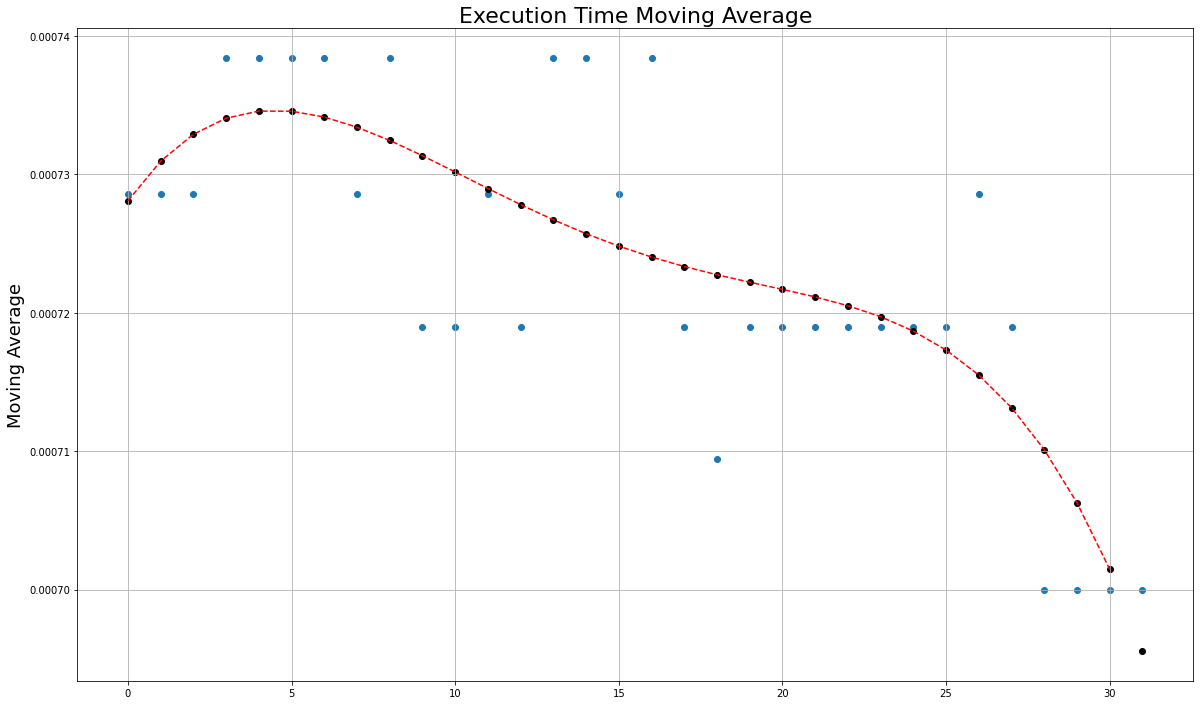

<ipython-input-35-f047f0f1f882>:61: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if maxima[0] < minima[0]:


IndexError: index 0 is out of bounds for axis 0 with size 0

In [35]:
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low <= high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid][0] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid][0] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
 
    # If we reach here, then the element was not present
    return -1

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

window = 10  # size of the sliding window

def plot_ma_seq():
    
    points_filtered.sort(key=lambda p: p[0])
    ys = []
    for p in range(0, len(points_filtered) - window, 5):
        sample = points_filtered[p:p+window]
        ys.append(geo_mean([s[1] for s in sample]))
        
    xs = [i for i in range(len(ys))]

    # find parabola of best fit
    # a * x^3 + b * x^2 + c * x + d
    a, b, c, d, e = parabola_best_fit(xs, ys)
    
    zs = [objective(x, a, b, c, d, e) for x in xs]
    if MODE != "text":
        plt.scatter(xs, zs, color="black")  # project data points onto the curve
        plt.show()

    # for local maxima
    maxima = argrelextrema(np.array(zs), np.greater)

    # for local minima
    minima = argrelextrema(np.array(zs), np.less)
    
    pair = find_pairs(xs, ys, maxima, minima)
    print(pair[0], pair[1])


def find_pairs(xs, ys, maxima, minima):
    if maxima[0] < minima[0]:
        # trending downwards
        i = int(maxima[0][0])
        j = int(minima[0][0])
        first_group = [points_filtered[x] for x in range(5*xs[i], 5*xs[i] + window)]
        second_group = [points_filtered[x] for x in range(5*xs[j], 5*xs[j] + window)]
        first_group_max = max(first_group, key=lambda x: x[1])
        second_group_min = min(second_group, key=lambda x: x[1])
        return first_group_max[3]["label"], second_group_min[3]["label"]
    else:
        # trending upwards
        j = int(maxima[0][0])
        i = int(minima[0][0])
        first_group = [points_filtered[x] for x in range(5*xs[i], 5*xs[i] + window)]
        second_group = [points_filtered[x] for x in range(5*xs[j], 5*xs[j] + window)]
        first_group_min = min(first_group, key=lambda x: x[1])
        second_group_max = max(second_group, key=lambda x: x[1])
        return first_group_min[3]["label"], second_group_max[3]["label"]

plot_ma_seq()
# print(url)

In [12]:
def plot_ma_date():

    window = 10  # size of the sliding window
    points_filtered.sort(key=lambda p: p[2])
    ys = []
    for p in range(0, len(points_filtered) - window, 5):
        sample = points_filtered[p:p+window]
        ys.append(sum([s[1] for s in sample])/len(sample))
        
    xs = [i for i in range(len(ys))]
    
    fig = plt.figure(figsize=(20,12))
    ax1 = plt.plot(xs, ys)
    ax1 = plt.title("Execution Time Moving Average", fontsize=22)
    ax1 = plt.xlabel("Sequence", fontsize=18)
    ax1 = plt.ylabel("Moving Average", fontsize=18)
    # ax1 = plt.legend(["100 day SMA"],prop={"size":20}, loc="upper left")
    plt.grid(True)
    plt.show()

    max_diff = float("-inf")
    last = None
    for i in range(len(ys)):
        if not last:
            last = ys[i]
        else:
            if abs(last - ys[i]) > max_diff:
                max_diff = abs(last - ys[i])
                
    if path.exists("results/analysis/" + filename + "_analysis_time.txt"):
        os.remove("results/analysis/" + filename + "_analysis_time.txt")

    last = None
    for i in range(len(ys)):
        if not last:
            last = ys[i]
        else:
            if abs(last - ys[i]) > 0.8 * max_diff:
#                 print(xs[i])
#                 print("{}, {}".format(xs[i - 1], xs[i])) TODO
                last_group = [points_filtered[x] for x in range(5*xs[i-1], 5*xs[i-1] + window)]
                curr_group = [points_filtered[x] for x in range(5*xs[i], 5*xs[i] + window)]
                
                with open("results/analysis/" + filename + "_analysis_time.txt", "a") as f:
                    #. write analysis
                    f.write("first group: {}\nsecond group: {}\n\n".format([p[3]["label"] for p in last_group], [p[3]["label"] for p in curr_group]))
                    
                if last - ys[i] > 0:
                    # graph trending downward
                    last_group_min = max(last_group, key=lambda x: x[1])
                    curr_group_min = min(curr_group, key=lambda x: x[1])
                else:
                    # graph trending upward
                    last_group_min = min(last_group, key=lambda x: x[1])
                    curr_group_min = max(curr_group, key=lambda x: x[1])
                    
                print("{}, {}".format(last_group_min[3]["label"], curr_group_min[3]["label"]))
                
# plot_ma_date()